In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json

## Plot LMP

In [3]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
rundate = datetime(2024,10,18).strftime("%Y-%m-%d")
# policies = ['PF', 'MF', 'BF', 'WF', 'DR', 'DR30']
policies = ['MF', 'BF', 'WF']

In [4]:
from datetime import datetime
import collections
LMPS = collections.defaultdict(list)
min_LMP = collections.defaultdict(list)
time_index = []
for POLICY in policies:
    UCpath_dir = os.path.join(res_dir, rundate, POLICY, POLICY+'_'+rundate)
    if os.path.exists(UCpath_dir) == False:
        continue
    filedates = [datetime(2019,1,1).strftime("%Y-%m-%d")] #, datetime(2019,2,1).strftime("%Y-%m-%d")]
    for filename in filedates:
        file = os.path.join(UCpath_dir, "UC_"+filename+'.json')
        with open(file, 'r') as f:
            data = json.load(f)
            LMPS[POLICY].extend(data['Hourly average LMP'])
            if len(time_index) == 0:
                time_index.extend(data['Time'])
    EDpath_dir = os.path.join(res_dir, rundate, POLICY, 'ED_'+POLICY+'_'+rundate)
    for filename in filedates:
        ed_file = os.path.join(EDpath_dir, "ED_"+filename+'.json')
        with open(ed_file, 'r') as f:
            data = json.load(f)
            for d in data['LMP']:
                min_LMP[POLICY].extend(d)

In [8]:
import math
min_len = min([len(LMPS[key]) for key in LMPS.keys()])
LMPS = {key: LMPS[key][:min_len] for key in LMPS.keys()}
LMP_df = pd.DataFrame(LMPS)
# LMP_df.insert(0, 'Time', time_index)
# LMP_df.Time = pd.to_datetime(LMP_df.Time)
# print('Rundate is', rundate)
# LMP_df.describe().round(2)

In [9]:
LMP_df.mean()

MF    38.580138
BF    26.122868
WF    23.673560
dtype: float64

In [35]:
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'), index_col=0)
df.rename(index={'NR': 'MF'}, inplace=True)
totalcosts = [df.loc[p]['TotalCosts'] for p in policies]


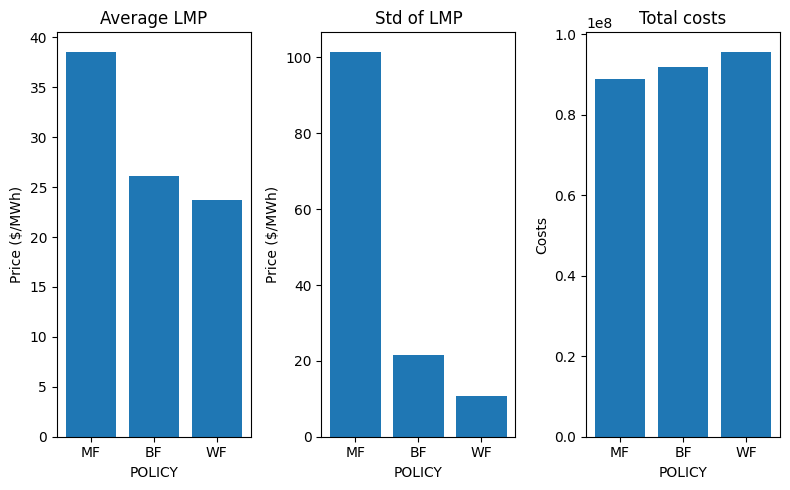

In [44]:
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'), index_col=0)
x = np.arange(len(policies))

fig, ax = plt.subplots(1,3, figsize=(8,5))
for i in range(3):
    if i == 0:
        ax[i].bar(x, LMP_df.mean())
        ax[i].set_ylabel('Price ($/MWh)')
        ax[i].set_title('Average LMP')
    elif i == 1:
        ax[i].bar(x, LMP_df.std(), align='center', ecolor='black', capsize=5)
        ax[i].set_ylabel('Price ($/MWh)')
        ax[i].set_title('Std of LMP')
    else:
        ax[i].bar(x, totalcosts, align='center', ecolor='black', capsize=5)
        ax[i].set_ylabel('Costs')
        ax[i].set_title('Total costs')
    ax[i].set_xticks(x)  # Centering the labels
    ax[i].set_xlabel('POLICY')
    ax[i].set_xticklabels(policies)

plt.tight_layout()
plt.show()


In [1]:
LMP_df

NameError: name 'LMP_df' is not defined

In [9]:
LMP_df.describe().round(2)

,BF
count,744.00
mean,441.98
std,1234.30
min,23.36
25%,32.18
50%,36.00
75%,78.94
max,5000.00


In [24]:
min_len = min([len(min_LMP[POLICY]) for POLICY in min_LMP.keys()])
min_LMP = {POLICY : min_LMP[POLICY][:min_len] for POLICY in min_LMP.keys()}
min_time_index = pd.date_range(start='2019-01-01', periods=min_len, freq='5T')
min_LMP_df = pd.DataFrame(min_LMP, index=min_time_index)

In [25]:
min_LMP_df.describe().round(2)

,PF,MF,BF,WF,DR
count,16992.00,16992.00,16992.00,16992.00,16992.00
mean,464.05,1062.37,199.41,56.10,799.96
std,1273.76,1855.08,776.95,282.95,1624.28
min,23.81,22.68,17.43,2.83,22.58
25%,32.05,32.82,31.47,30.53,32.82
50%,42.97,74.48,35.06,32.82,63.42
75%,113.90,498.71,58.06,35.45,261.21
max,5000.00,5000.00,5000.00,5000.00,5000.00


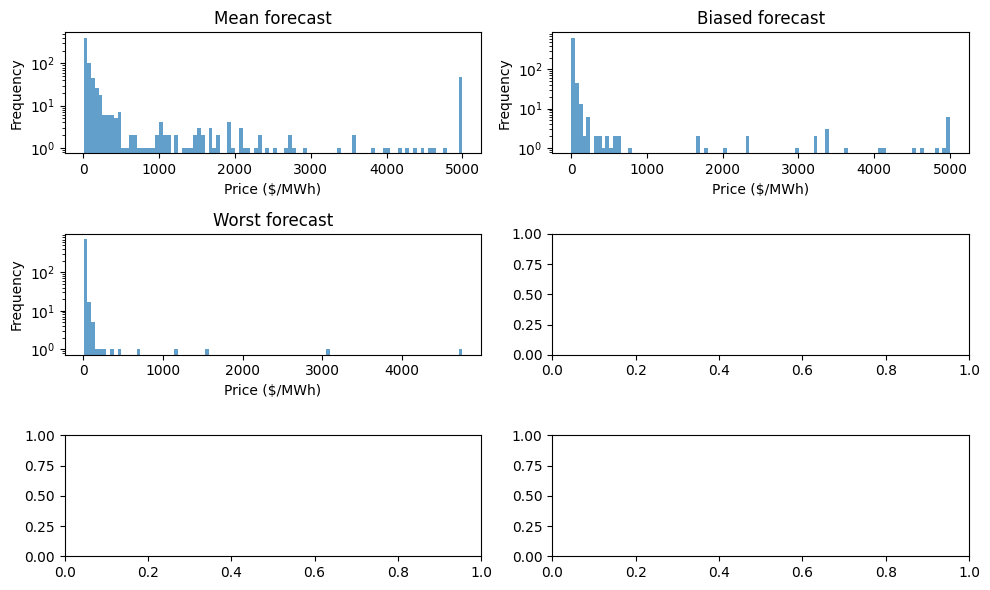

In [24]:
policy_names = {"SB": "Stochastic benchmark",
                "PF": "Perfect forecast", 
                "MF": "Mean forecast", 
                "BF":"Biased forecast", 
                "WF": "Worst forecast", 
                "DR":"Dynamic uncertainty reserve",
                "DR30": "Dynamic uncertainty reserve added to 30T"}
fig, ax = plt.subplots(3,2, figsize=(10,6))
for i in range(len(LMP_df.columns)-1):
    ax[i//2, i%2].hist(LMP_df.iloc[:,i+1], bins=100, alpha=0.7)
    ax[i//2, i%2].set_title(policy_names[LMP_df.columns[i+1]])
    ax[i//2, i%2].set_xlabel("Price ($/MWh)")
    ax[i//2, i%2].set_ylabel("Frequency")
    ax[i//2, i%2].set_yscale('log')
    # ax[i//2, i%2].set_xlim(-25, 200)
    # ax[i//2, i%2].grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


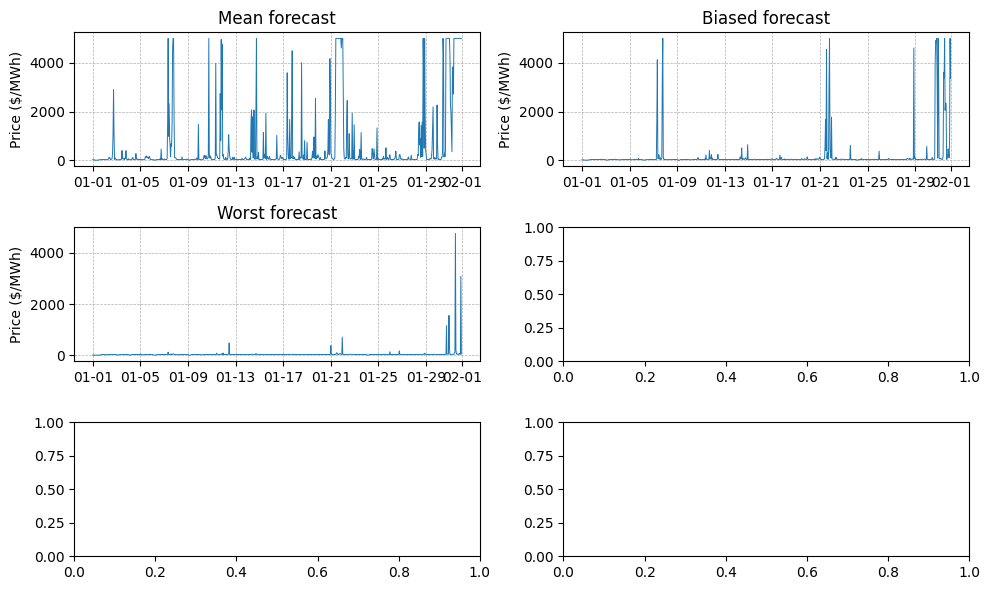

In [25]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(3,2, figsize=(10,6))
for i in range(len(LMP_df.columns)-1):
    ax[i//2, i%2].plot(LMP_df.Time, LMP_df.iloc[:,i+1], linewidth=0.7)
    ax[i//2, i%2].set_title(policy_names[LMP_df.columns[i+1]])
    ax[i // 2, i % 2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i // 2, i % 2].tick_params(axis='x')
    ax[i//2, i%2].set_ylabel("Price ($/MWh)")
    ax[i//2, i%2].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

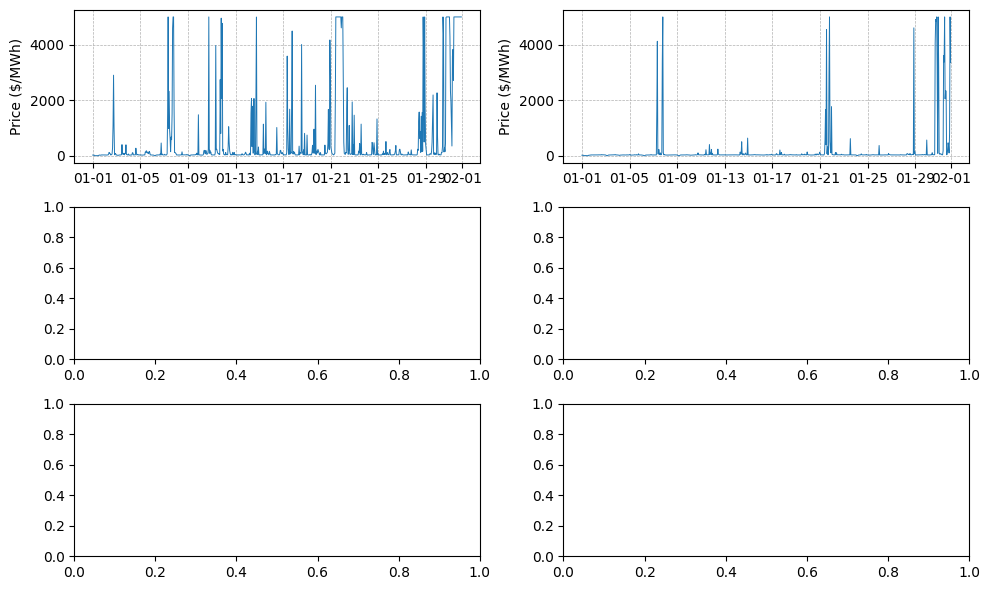

In [20]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(3,2, figsize=(10,6))
for i in range(len(LMP_df.columns)-1):
    ax[i//2, i%2].plot(LMP_df.Time, LMP_df.iloc[:,i+1], linewidth=0.7)
    # ax[i//2, i%2].set_title(policy_names[LMP_df.columns[i+1]])
    ax[i // 2, i % 2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i // 2, i % 2].tick_params(axis='x')
    ax[i//2, i%2].set_ylabel("Price ($/MWh)")
    ax[i//2, i%2].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [5]:
# POLICY = "WF"
# rundate = datetime(2024,10,20).strftime("%Y-%m-%d")
# filedate = datetime(2019,1,1).strftime("%Y-%m-%d")
# file = os.path.join(res_dir, "Master_"+POLICY, POLICY+'_'+rundate, f"UC_{filedate}.json")
# with open(file, 'r') as f:
#     data = json.load(f)
#     LMPS["WF2"] = data['Hourly average LMP']

In [127]:
min_len

497

In [10]:
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'))
df

,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_curt,Solar_curt
0,PF,1.350326e+10,7.305790e+07,8.513758e+08,5.921389e+09,9.333266e+07,1.674908e+10,2.221492e+10,5.977985e+08,33833.038139,4.261342e+08,2499124.0,1.691652e+08,595627.755723,950347.583485
1,MF,3.044285e+10,2.414233e+08,1.964891e+09,1.274785e+10,1.254652e+08,3.620525e+10,4.777308e+10,1.356812e+09,179846.233084,4.530443e+08,4536394.0,8.992312e+08,595627.755723,950347.583485
2,BF,5.966232e+09,4.421005e+07,3.525015e+08,2.424478e+09,2.586900e+07,6.887702e+09,9.246304e+09,4.973916e+08,15157.536136,4.158120e+08,5791926.0,7.578768e+07,595627.755723,950347.583485
3,WF,1.610340e+09,1.678214e+06,6.043111e+07,6.798115e+08,2.960268e+06,1.592805e+09,2.223459e+09,4.222232e+08,1262.483857,4.070683e+08,8842548.0,6.312419e+06,595627.755723,950347.583485
4,DR,2.314509e+10,2.258180e+08,1.372619e+09,9.413458e+09,9.749009e+07,2.695326e+10,3.563061e+10,1.021252e+09,112948.332920,4.516116e+08,4898248.0,5.647417e+08,595627.755723,950347.583485


[Text(0.2, 0, 'PF'),
 Text(1.2, 0, 'MF'),
 Text(2.2, 0, 'BF'),
 Text(3.2, 0, 'WF'),
 Text(4.2, 0, 'DR')]

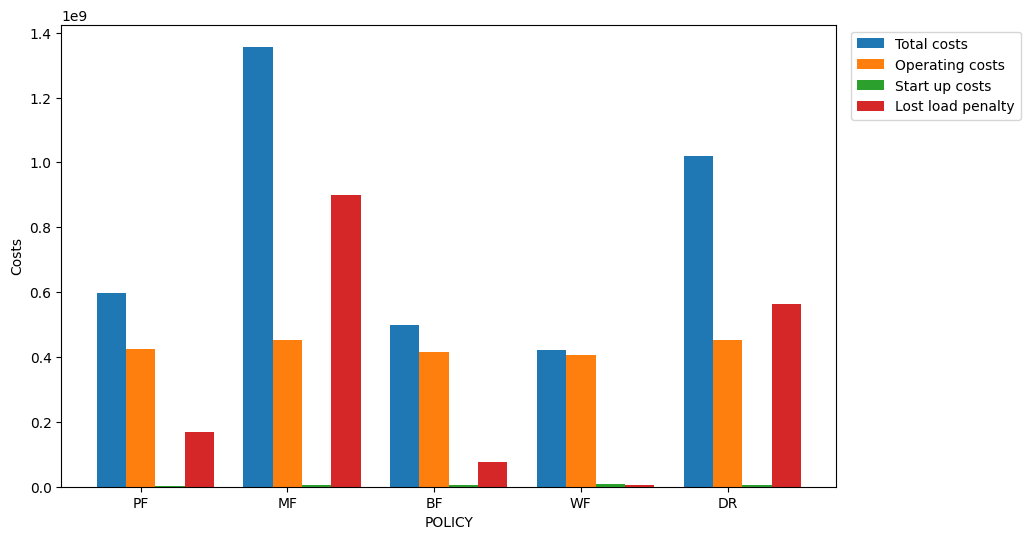

In [11]:
x = np.arange(len(df['POLICY']))
plotcols = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty']
colnames = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty']
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(4):
    ax.bar(x + i*width, df[plotcols[i]], width, label=colnames[i])
ax.set_xlabel('POLICY')
ax.set_ylabel('Costs')
# ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xticks(x + width)  # Centering the labels
ax.set_xticklabels(df['POLICY'])

[Text(0.2, 0, 'PF'),
 Text(1.2, 0, 'MF'),
 Text(2.2, 0, 'BF'),
 Text(3.2, 0, 'WF'),
 Text(4.2, 0, 'DR')]

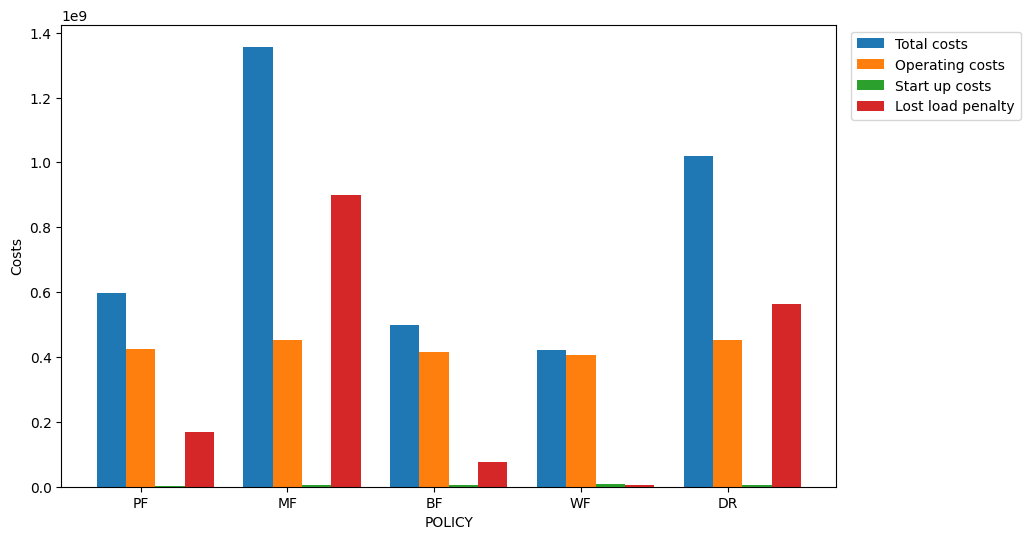

In [16]:
x = np.arange(len(df['POLICY']))
plotcols = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty']
colnames = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty']
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(4):
    ax.bar(x + i*width, df[plotcols[i]], width, label=colnames[i])
ax.set_xlabel('POLICY')
ax.set_ylabel('Costs')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xticks(x + width)  # Centering the labels
ax.set_xticklabels(df['POLICY'])

In [17]:

df

,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_curt,Solar_curt
0,PF,1.350326e+10,7.305790e+07,8.513758e+08,5.921389e+09,9.333266e+07,1.674908e+10,2.221492e+10,5.977985e+08,33833.038139,4.261342e+08,2499124.0,1.691652e+08,595627.755723,950347.583485
1,MF,3.044285e+10,2.414233e+08,1.964891e+09,1.274785e+10,1.254652e+08,3.620525e+10,4.777308e+10,1.356812e+09,179846.233084,4.530443e+08,4536394.0,8.992312e+08,595627.755723,950347.583485
2,BF,5.966232e+09,4.421005e+07,3.525015e+08,2.424478e+09,2.586900e+07,6.887702e+09,9.246304e+09,4.973916e+08,15157.536136,4.158120e+08,5791926.0,7.578768e+07,595627.755723,950347.583485
3,WF,1.610340e+09,1.678214e+06,6.043111e+07,6.798115e+08,2.960268e+06,1.592805e+09,2.223459e+09,4.222232e+08,1262.483857,4.070683e+08,8842548.0,6.312419e+06,595627.755723,950347.583485
4,DR,2.314509e+10,2.258180e+08,1.372619e+09,9.413458e+09,9.749009e+07,2.695326e+10,3.563061e+10,1.021252e+09,112948.332920,4.516116e+08,4898248.0,5.647417e+08,595627.755723,950347.583485


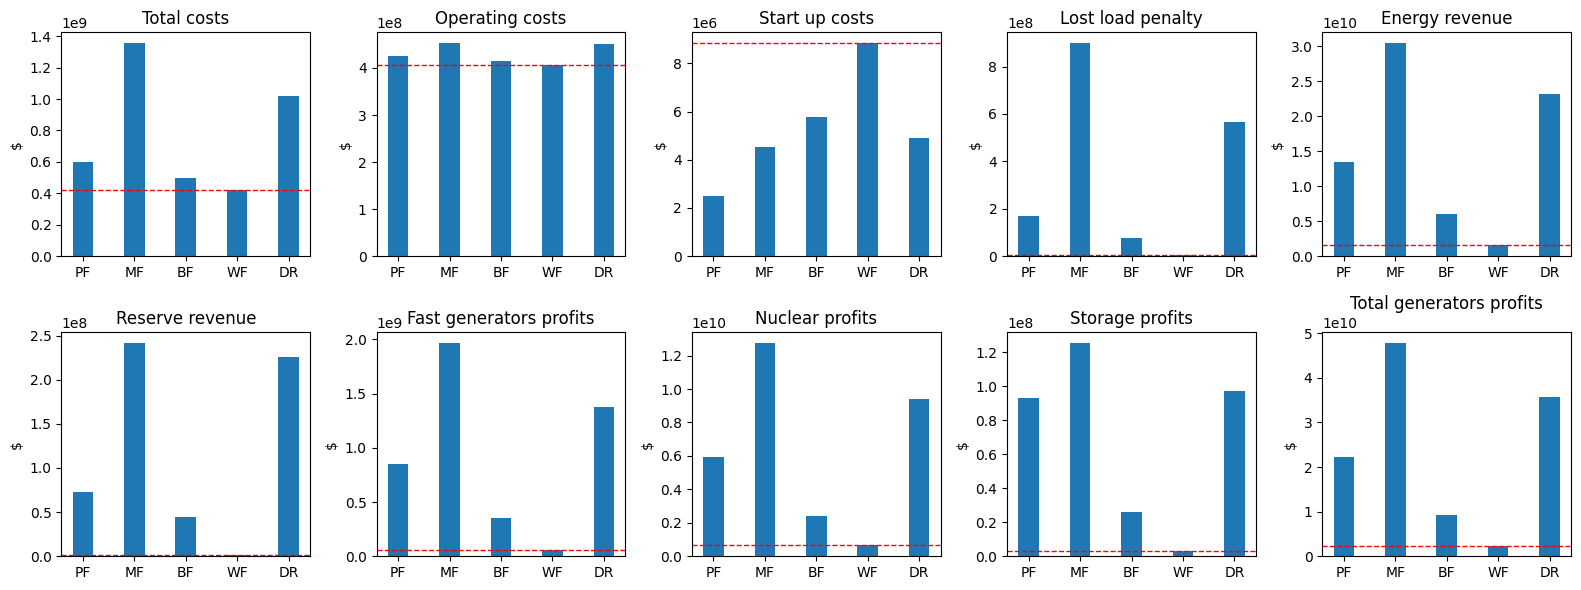

In [28]:
# plotcols = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty']
# colnames = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty']
columns = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty', 'Gen_energy_revenue', 'Gen_reserve_revenue', 'Fast_gen_profits', 'Nuclear_profits', 'Storage_profits', 'All_gen_profits']
column_titles = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty', 'Energy revenue', 'Reserve revenue', 'Fast generators profits', 'Nuclear profits', 'Storage profits', 'Total generators profits']
x = np.arange(len(df['POLICY']))  # Label locations for categories
width = 0.4  # Width of each bar

# Plotting the bars
fig, ax = plt.subplots(2,5,figsize=(16,6))
for i in range(len(columns)):
    ax[i//5, i%5].bar(df['POLICY'], [df.iloc[j][columns[i]] for j in range(len(df))], width)
    ax[i//5, i%5].axhline(y=df.iloc[3][columns[i]], color='red', linestyle='--', linewidth=1) #plot(, linestyle = '--', color='red', label='Base case')
    ax[i//5, i%5].set_ylabel('$')
    ax[i//5, i%5].set_xticks(x)  # Centering the labels
    ax[i//5, i%5].set_title(column_titles[i])
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

In [32]:
df

,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_curt,Solar_curt
0,PF,1.350326e+10,7.305790e+07,8.513758e+08,5.921389e+09,9.333266e+07,1.674908e+10,2.221492e+10,5.977985e+08,33833.038139,4.261342e+08,2499124.0,1.691652e+08,595627.755723,950347.583485
1,MF,3.044285e+10,2.414233e+08,1.964891e+09,1.274785e+10,1.254652e+08,3.620525e+10,4.777308e+10,1.356812e+09,179846.233084,4.530443e+08,4536394.0,8.992312e+08,595627.755723,950347.583485
2,BF,5.966232e+09,4.421005e+07,3.525015e+08,2.424478e+09,2.586900e+07,6.887702e+09,9.246304e+09,4.973916e+08,15157.536136,4.158120e+08,5791926.0,7.578768e+07,595627.755723,950347.583485
3,WF,1.610340e+09,1.678214e+06,6.043111e+07,6.798115e+08,2.960268e+06,1.592805e+09,2.223459e+09,4.222232e+08,1262.483857,4.070683e+08,8842548.0,6.312419e+06,595627.755723,950347.583485
4,DR,2.314509e+10,2.258180e+08,1.372619e+09,9.413458e+09,9.749009e+07,2.695326e+10,3.563061e+10,1.021252e+09,112948.332920,4.516116e+08,4898248.0,5.647417e+08,595627.755723,950347.583485


In [33]:
perunint_df = pd.read_csv(os.path.join(res_dir, rundate, 'PerUnitProfit.csv'))
perunint_df.round(2)

,POLICY,Fast,Nuclear,Thermal,BA,PH,wind,solar,hydro
0,PF,276897.18,1090495.26,515448.22,61885.85,430.67,621304.34,21368.02,860268.73
1,MF,639051.30,2347670.71,1114206.60,83210.78,554.74,1326969.78,347628.10,1797765.95
2,BF,114645.83,446496.87,211967.11,17092.17,197.22,309075.53,57202.39,352070.17
3,WF,19654.31,125195.48,49018.14,1978.39,-6.25,83685.36,13877.72,94685.83
4,DR,446423.66,1733601.91,829479.14,64864.02,165.87,1007239.79,262559.30,1342762.25


In [34]:
rundate

'2024-11-11'

In [49]:
perunint_df.columns[3]

'Thermal'

In [17]:
hydro_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/NYGrid/hydro_2019.csv')
print("The maximum hydro generation is: ", hydro_df.Gen_MW.max())
wind_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/ARPAE_NYISO/Clean_CSV/Hour/wind_actuals_2019_hourly_BA.csv')
print("The maximum wind generation is: ", wind_df.BA_total.max())
solar_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/ARPAE_NYISO/Clean_CSV/Hour/solar_actuals_2019_hourly_BA.csv')
print("The maximum solar generation is: ", solar_df.BA_total.max())

The maximum hydro generation is:  4738.0
The maximum wind generation is:  1798.6622698166666
The maximum solar generation is:  448.9000012899999


In [61]:
solar_df.describe().round(2)
wind_df.describe().round(2)

,hour,BA_total
count,8760.00,8760.00
mean,11.50,88.89
std,6.92,126.62
min,0.00,0.00
25%,5.75,0.00
50%,11.50,2.23
75%,17.25,161.53
max,23.00,448.90
